In [96]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Function to load images and labels
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for emotion_label in os.listdir(folder_path):  # Loop through emotion folders
        emotion_folder = os.path.join(folder_path, emotion_label)
        if os.path.isdir(emotion_folder):
            for img_file in os.listdir(emotion_folder):  # Loop through images
                img_path = os.path.join(emotion_folder, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                if img is not None:
                    img_resized = cv2.resize(img, (48, 48))  # Resize image to 48x48
                    images.append(img_resized.flatten())  # Flatten to 1D array
                    labels.append(emotion_label)  # Use folder name as label
    return images, labels

# Path to CK+48 dataset
dataset_folder = r"D:\Reserach\svm3\CK+48"

# Load the dataset
X, y = load_images_from_folder(dataset_folder)
X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y)

# Encode emotion labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=100)  # Experiment with this value
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Define KNN model
knn = KNeighborsClassifier()

# Hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the model
y_pred = grid_search.predict(X_test_pca)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Test Accuracy: 92.39%

Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.89      0.94        27
    contempt       0.92      1.00      0.96        11
     disgust       0.83      0.86      0.85        35
        fear       1.00      0.93      0.97        15
       happy       0.91      0.93      0.92        42
     sadness       0.94      0.94      0.94        17
    surprise       0.94      0.96      0.95        50

    accuracy                           0.92       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.92      0.92       197


Confusion Matrix:
[[24  0  3  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  0 30  0  4  1  0]
 [ 0  0  1 14  0  0  0]
 [ 0  0  0  0 39  0  3]
 [ 0  1  0  0  0 16  0]
 [ 0  0  2  0  0  0 48]]


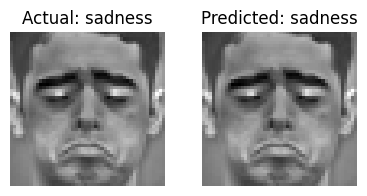

In [97]:
import matplotlib.pyplot as plt  # Visualization

emotions_to_display = ['sadness']
displayed_emotions = {emotion: 0 for emotion in emotions_to_display}  # Track displayed images
num_per_emotion = 1  # Number of images to display per emotion

# Create a list to store the subplots for each emotion
all_images = []

# Iterate over the test set
for i in range(len(X_test)):
    true_label = label_encoder.inverse_transform([y_test_encoded[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[i]])[0]

    # Check if we need to display this emotion
    if true_label in emotions_to_display and displayed_emotions[true_label] < num_per_emotion:
        # Store the images and labels for later plotting
        all_images.append((X_test[i], true_label, pred_label))
        displayed_emotions[true_label] += 1

    # Stop once all emotions have been displayed
    if all(count >= num_per_emotion for count in displayed_emotions.values()):
        break

# Create a figure for displaying the images
fig, axes = plt.subplots(
    1, 
    num_per_emotion * 2, 
    figsize=(4, 2)  # Larger figure size for clarity
)

# Ensure `axes` is iterable
if num_per_emotion * 2 == 1:
    axes = [axes]  # Wrap single subplot in a list

# Display the images
for col, (image, true_label, pred_label) in enumerate(all_images):
    # Actual image
    ax_actual = axes[col * 2]
    ax_actual.imshow(image.reshape(48, 48), cmap='gray')
    ax_actual.set_title(f"Actual: {true_label}")
    ax_actual.axis('off')

    # Predicted image
    ax_pred = axes[col * 2 + 1]
    ax_pred.imshow(image.reshape(48, 48), cmap='gray')
    ax_pred.set_title(f"Predicted: {pred_label}")
    ax_pred.axis('off')

plt.tight_layout()
plt.show()
